# Logistics Regression 

---

### Import Libraries and Dependencies

In [1]:
# Initial imports
import os
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
# from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import talib

### Read CSV / API into Pandas DataFrame

In [2]:
# Loading data
# Create a list of all csv files in the data directory
data_dir = "Resources/Data/"
dir_content = os.listdir(data_dir)
data_files = [data_dir + x for x in dir_content if x.lower().endswith('.csv')]
data_files.sort()
data_files

['Resources/Data/AAPL.csv',
 'Resources/Data/AMZN.csv',
 'Resources/Data/BABA.csv',
 'Resources/Data/BTCUSD=X.csv',
 'Resources/Data/EMR.csv',
 'Resources/Data/EURUSD=X.csv',
 'Resources/Data/EXC.csv',
 'Resources/Data/F.csv',
 'Resources/Data/GBPUSD=X.csv',
 'Resources/Data/GOOG.csv',
 'Resources/Data/Gold.csv',
 'Resources/Data/HYG.csv',
 'Resources/Data/JPM.csv',
 'Resources/Data/KO.csv',
 'Resources/Data/LQD.csv',
 'Resources/Data/MMM.csv',
 'Resources/Data/MSCI Europe.csv',
 'Resources/Data/Nikkei Index.csv',
 'Resources/Data/Oil.csv',
 'Resources/Data/PFE.csv',
 'Resources/Data/Russell 2000.csv',
 'Resources/Data/SIEGY.csv',
 'Resources/Data/SPG.csv',
 'Resources/Data/SSNLF.csv',
 'Resources/Data/TSLA.csv']

### Calculate Indicators and Prepare Data

In [3]:
def add_indicators_and_signals(df):

    #df = df.drop(["Adj Close", "Ticker"], axis=1)
    
    if 'High' in df.columns:
        stock_high = df['High']
    else:
        stock_high = None
        
    if 'Low' in df.columns:
        stock_low = df['Low']
    else:
        stock_low = None
            
    if 'Open' in df.columns:
        stock_open = df['Open']
    else:
        stock_open = None
        
    if 'Volume' in df.columns:
        stock_volume = df['Volume']
    else:
        stock_volume = None
        
    if 'Adj Close' in df.columns:
        stock_close = df['Adj Close']
    else:
        stock_close = df['Close']
    
    # MACD, MACD Histogram
    df['MACD'], df['MSIG'], df['MACDH'] = talib.MACD(stock_close, fastperiod=12, slowperiod=26, signalperiod=9)

    # MACD > MSIG: Buy
    # MACD < MSIG: Sell
    df['MACD Sig'] = np.where(df['MACD'] > df['MSIG'], 1, 0) + np.where(df['MACD'] < df['MSIG'], -1, 0)

    # MACD Histogram (MACDH) 
    df['MACDH Sig'] = np.where(df['MACDH'] > 0, 1, 0) + np.where(df['MACDH'] < 0, -1, 0)
    
    # ---------------------------------------------
    
    # Compute Average Directional Index (ADX)
    if stock_low is not None and stock_high is not None:
        df['ADX'] = talib.ADX(stock_high, stock_low, stock_close, timeperiod=14)

        # ADX > 25: Strong Trend Strength 
        # ADX < 20: Weak Trend Strength
        df['ADX Sig'] = np.where(df['ADX'] > 25, 1, 0) + np.where(df['ADX'] < 20, -1, 0)
    
    # ---------------------------------------------
    
    # Compute Relatie Strength Index (RSI)
    df['RSI'] = talib.RSI(stock_close, timeperiod=14)

    # RSI < 30: Over sold -> Buy
    # RSI > 70: Over bought -> Sell
    df['RSI Sig'] = np.where(df['RSI'] < 30, 1, 0) + np.where(df['RSI'] > 70, -1, 0)
    
    # ---------------------------------------------
    
    # Compute Bollinger Bands
    df['BB Upper'], df['BB middle'], df['BB Lower'] = talib.BBANDS(stock_close, timeperiod=26)
    df['BB Sig'] = np.where(stock_close < df['BB Lower'], 1, 0) + np.where(stock_close > df['BB Upper'], -1, 0)
    
    # ---------------------------------------------
    
    # Compute Force Index
    if stock_volume is not None:
        #df['FI'] = stock_volume * (stock_close - stock_close.shift(1))
        df['FI'] = stock_volume * stock_close.diff()
        df['EFI'] = talib.EMA(df['FI'], timeperiod=13)

        # Remove Scientific Notation from columns FI and EFI
        pd.options.display.float_format = '{:.2f}'.format

        df['EFI Sig'] = np.where(df['EFI'] > 0, 1, -1)
    
    # ---------------------------------------------
    
    # Calculate 5 day simple movering average
    df['SMA 5'] = stock_close.transform(lambda x: x.rolling(window = 5).mean())

    # Calculate 15 day simple movering average
    df['SMA 15'] = stock_close.transform(lambda x: x.rolling(window = 15).mean())

    # Calculate simple moving average ratio to capture the relationship between the two moving averages
    df['SMA 15/5'] = df['SMA 15'] / df['SMA 5']

    # Calculate Signal for SMA 200/50
    df['SMA 15/5 Sig'] = np.where(df['SMA 5'] > df['SMA 15'], 1.0, 0.0) + np.where(df['SMA 5'] < df['SMA 15'], -1.0, 0.0)
    
    # --------------------------------------------
    
    # Calculate 5 day exp movering average
    df['EMA 5'] = talib.EMA(stock_close, timeperiod=5)

    # Calculate 10 day exp movering average
    df['EMA 15'] = talib.EMA(stock_close, timeperiod=15)

    # Calculate exp moving average ratio to capture the relationship between the two moving averages
    df['EMA 15/5'] = df['EMA 15'] / df['EMA 5']

    # Calculate Signal for SMA 200/50
    df['EMA 15/5 Sig'] = np.where(df['EMA 5'] > df['SMA 15'], 1.0, 0.0) + np.where(df['SMA 5'] < df['SMA 15'], -1.0, 0.0)
    
    ##############################################################
    
    # Calculate daily return
    df['Returns'] = df['Close'].pct_change()
    # Create Target column
    df['Target'] = np.where(df['Returns'] >= 0, 1.0, -1)
    
    # Shift Target column by index -1 (compare today's values with tomorrow's trend)
    df['Target'] = df['Target'].shift(-1)

    # Replacing infinite with nan 
    df.replace([np.inf, -np.inf], np.nan, inplace=True) 

    # Dropping all the rows with nan values 
    df.dropna(inplace=True) 
    
    return df

In [4]:
def log_reg_indicators_only(df, ticker):
    # Define features set
    X = df.copy()
    
    # Drop useless columns
    signal_columns = [col for col in X.columns if col.endswith(' Sig')]
    X.drop(signal_columns, axis=1, inplace=True)
    X.drop(['Ticker', 'Returns', 'Target'], axis=1, inplace=True)

    # Some tickers do not have these indicators
    if 'ADX Sig' in X.columns:
        X.drop('ADX Sig', axis=1, inplace=True)

    if 'EFI Sig' in X.columns:
        X.drop('EFI Sig', axis=1, inplace=True)
    
    # Define target vector
    y = df["Target"].ravel()
    
    # Splitting into Train and Test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
    
    # Creating StandardScaler instance
    scaler = StandardScaler()
    
    # Fitting Standard Scaller
    X_scaler = scaler.fit(X_train)
    
    # Scaling data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create a Logistic Regression classifier
    log_reg_model = LogisticRegression(solver='lbfgs', max_iter=5000)
    
    # Fitting the model
    log_reg_model = log_reg_model.fit(X_train_scaled, y_train)
    
    # Making predictions using the testing data
    predictions = log_reg_model.predict(X_test_scaled)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
    )

    # Calculating the accuracy score
    acc_score = accuracy_score(y_test, predictions)
    
    # Displaying results
    print(f'\n{ticker}: Confusion Matrix (Indicators Only, No Signals)')
    display(cm_df)
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(classification_report(y_test, predictions))
    
    return log_reg_model, X.columns

In [5]:
def log_reg_signals_only(df, ticker):
    # Define features set
    X = df.copy()
    
    # Only keep signal columns
    column_to_keep = [col for col in X.columns if col.endswith(' Sig')]
    X = X[column_to_keep]
    
    # Define target vector
    y = df["Target"].ravel()
    
    # Splitting into Train and Test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
    
    # Creating StandardScaler instance
    scaler = StandardScaler()
    
    # Fitting Standard Scaller
    X_scaler = scaler.fit(X_train)
    
    # Scaling data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Create a random forest classifier
    log_reg_model = LogisticRegression(solver='lbfgs', max_iter=5000)
    
    # Fitting the model
    log_reg_model = log_reg_model.fit(X_train_scaled, y_train)
    
    # Making predictions using the testing data
    predictions = log_reg_model.predict(X_test_scaled)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(
        cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
    )

    # Calculating the accuracy score
    acc_score = accuracy_score(y_test, predictions)
    
    # Displaying results
    print(f'\n{ticker}: Confusion Matrix (Signals Only, No Indicators)')
    display(cm_df)
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(classification_report(y_test, predictions))
    
    return log_reg_model, X.columns

In [6]:
def features_importances(ticker, log_reg_model, X_columns):
    feature_importance = abs(log_reg_model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance )
    pos = np.arange(sorted_idx.shape[0]) + .5
    
    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos,feature_importance[sorted_idx], align='center', color='lightgreen')
    featax.set_xlabel(f'{ticker} Features Importances')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array( X_columns)[sorted_idx], fontsize=8)
    
    
    
    
#     # Random Forests in sklearn will automatically calculate feature importance
#     importances = lr_model.feature_importances_
    
#     # We can sort the features by their importance
#     sorted(zip(lr_model.feature_importances_, X_columns), reverse=True)
    
#     # Visualize the features by importance
#     importances_df = pd.DataFrame(sorted(zip(lr_model.feature_importances_, X_columns), reverse=True))
#     importances_df.set_index(importances_df[1], inplace=True)
#     importances_df.drop(columns=1, inplace=True)
#     importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
#     importances_sorted = importances_df.sort_values(by='Feature Importances')
    
#     chart = pos.plot(kind='barh', color='lightgreen', title= f'{ticker} Features Importances', legend=False) 
    plt.tight_layout()
    plt.show()
    return featax


### Run the Logistics Regression Model for only 1 ticker


AAPL: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,105,238
Actual 1,119,283


Accuracy Score : 0.5208053691275167
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.31      0.37       343
         1.0       0.54      0.70      0.61       402

    accuracy                           0.52       745
   macro avg       0.51      0.51      0.49       745
weighted avg       0.51      0.52      0.50       745



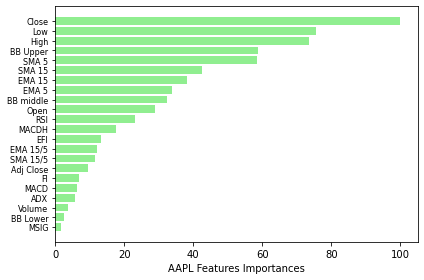


AAPL: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,124,219
Actual 1,153,249


Accuracy Score : 0.5006711409395973
Classification Report
              precision    recall  f1-score   support

        -1.0       0.45      0.36      0.40       343
         1.0       0.53      0.62      0.57       402

    accuracy                           0.50       745
   macro avg       0.49      0.49      0.49       745
weighted avg       0.49      0.50      0.49       745



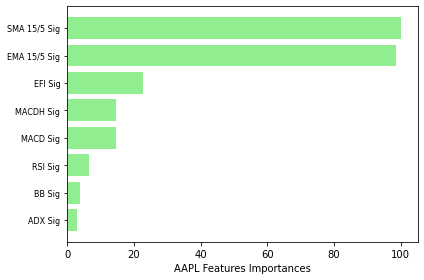

<AxesSubplot:xlabel='AAPL Features Importances'>

In [7]:
file_path = Path("Resources/Data/AAPL.csv")
df = pd.read_csv(file_path, index_col="Date")
ticker = df.Ticker.unique().tolist()[0]

# Calculate indicators and prepare data
df = add_indicators_and_signals(df)

# Make predictions using indicator values only and display confusion matrix
log_reg_model, X_columns = log_reg_indicators_only(df, ticker)

# Display importance features graph
features_importances(ticker, log_reg_model, X_columns)

# Make predictions using signals only and display confusion matrix
log_reg_model, X_columns = log_reg_signals_only(df, ticker)

# Display importance features graph
features_importances(ticker, log_reg_model, X_columns)


### Run the Random Forest Model for All the Data Files in the 'Resources/Data Folder'


----------------------- AAPL -----------------------


AAPL: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,105,238
Actual 1,119,283


Accuracy Score : 0.5208053691275167
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.31      0.37       343
         1.0       0.54      0.70      0.61       402

    accuracy                           0.52       745
   macro avg       0.51      0.51      0.49       745
weighted avg       0.51      0.52      0.50       745



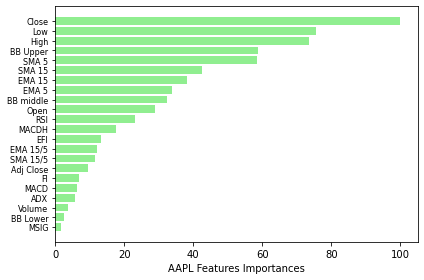

-----


AAPL: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,124,219
Actual 1,153,249


Accuracy Score : 0.5006711409395973
Classification Report
              precision    recall  f1-score   support

        -1.0       0.45      0.36      0.40       343
         1.0       0.53      0.62      0.57       402

    accuracy                           0.50       745
   macro avg       0.49      0.49      0.49       745
weighted avg       0.49      0.50      0.49       745



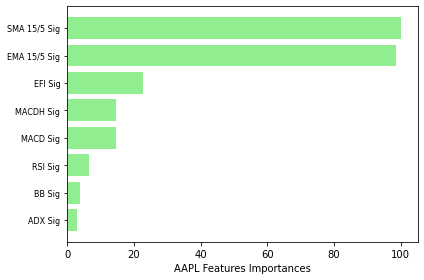


----------------------- AMZN -----------------------


AMZN: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,80,261
Actual 1,76,328


Accuracy Score : 0.5476510067114094
Classification Report
              precision    recall  f1-score   support

        -1.0       0.51      0.23      0.32       341
         1.0       0.56      0.81      0.66       404

    accuracy                           0.55       745
   macro avg       0.53      0.52      0.49       745
weighted avg       0.54      0.55      0.51       745



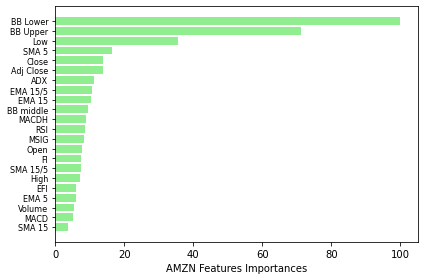

-----


AMZN: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,109,232
Actual 1,135,269


Accuracy Score : 0.5073825503355704
Classification Report
              precision    recall  f1-score   support

        -1.0       0.45      0.32      0.37       341
         1.0       0.54      0.67      0.59       404

    accuracy                           0.51       745
   macro avg       0.49      0.49      0.48       745
weighted avg       0.50      0.51      0.49       745



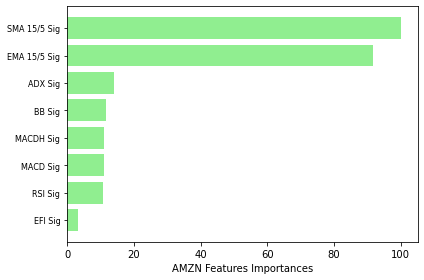


----------------------- BABA -----------------------


BABA: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,62,124
Actual 1,52,151


Accuracy Score : 0.5475578406169666
Classification Report
              precision    recall  f1-score   support

        -1.0       0.54      0.33      0.41       186
         1.0       0.55      0.74      0.63       203

    accuracy                           0.55       389
   macro avg       0.55      0.54      0.52       389
weighted avg       0.55      0.55      0.53       389



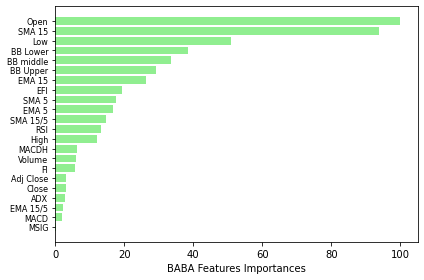

-----


BABA: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,95,91
Actual 1,92,111


Accuracy Score : 0.5295629820051414
Classification Report
              precision    recall  f1-score   support

        -1.0       0.51      0.51      0.51       186
         1.0       0.55      0.55      0.55       203

    accuracy                           0.53       389
   macro avg       0.53      0.53      0.53       389
weighted avg       0.53      0.53      0.53       389



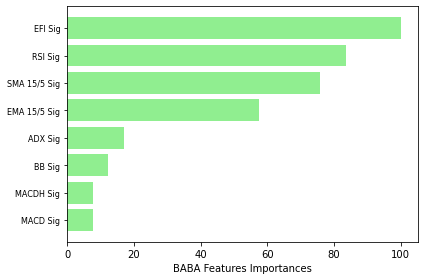


----------------------- BTCUSD=X -----------------------


BTCUSD=X: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,103,226
Actual 1,88,313


Accuracy Score : 0.5698630136986301
Classification Report
              precision    recall  f1-score   support

        -1.0       0.54      0.31      0.40       329
         1.0       0.58      0.78      0.67       401

    accuracy                           0.57       730
   macro avg       0.56      0.55      0.53       730
weighted avg       0.56      0.57      0.54       730



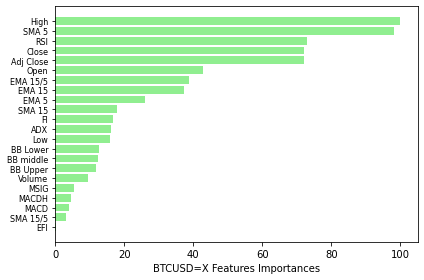

-----


BTCUSD=X: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,82,247
Actual 1,91,310


Accuracy Score : 0.536986301369863
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.25      0.33       329
         1.0       0.56      0.77      0.65       401

    accuracy                           0.54       730
   macro avg       0.52      0.51      0.49       730
weighted avg       0.52      0.54      0.50       730



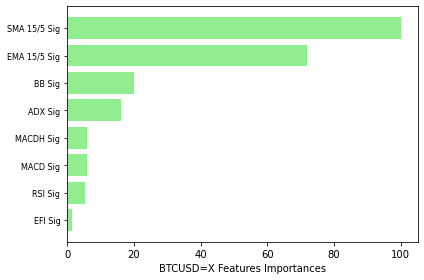


----------------------- EMR -----------------------


EMR: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,75,278
Actual 1,80,312


Accuracy Score : 0.5194630872483221
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.21      0.30       353
         1.0       0.53      0.80      0.64       392

    accuracy                           0.52       745
   macro avg       0.51      0.50      0.47       745
weighted avg       0.51      0.52      0.47       745



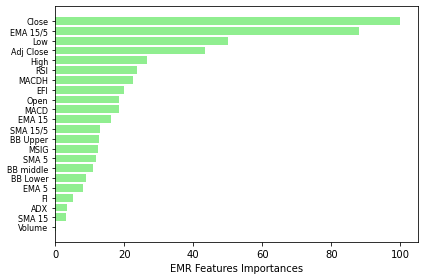

-----


EMR: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,13,340
Actual 1,20,372


Accuracy Score : 0.5167785234899329
Classification Report
              precision    recall  f1-score   support

        -1.0       0.39      0.04      0.07       353
         1.0       0.52      0.95      0.67       392

    accuracy                           0.52       745
   macro avg       0.46      0.49      0.37       745
weighted avg       0.46      0.52      0.39       745



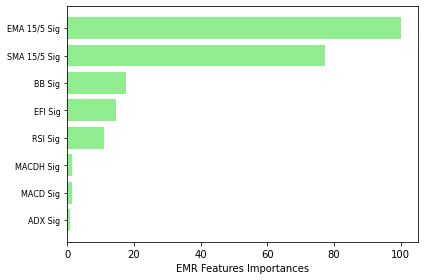


----------------------- EURUSD=X -----------------------


EURUSD=X: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,258,131
Actual 1,83,293


Accuracy Score : 0.7202614379084967
Classification Report
              precision    recall  f1-score   support

        -1.0       0.76      0.66      0.71       389
         1.0       0.69      0.78      0.73       376

    accuracy                           0.72       765
   macro avg       0.72      0.72      0.72       765
weighted avg       0.72      0.72      0.72       765



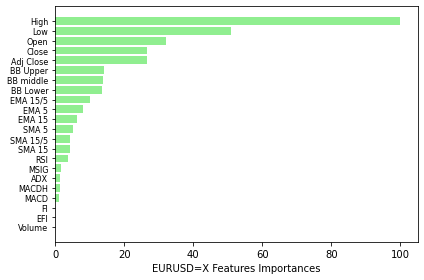

-----


EURUSD=X: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,149,240
Actual 1,162,214


Accuracy Score : 0.4745098039215686
Classification Report
              precision    recall  f1-score   support

        -1.0       0.48      0.38      0.43       389
         1.0       0.47      0.57      0.52       376

    accuracy                           0.47       765
   macro avg       0.48      0.48      0.47       765
weighted avg       0.48      0.47      0.47       765



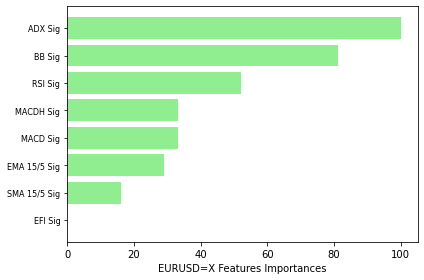


----------------------- EXC -----------------------


EXC: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,130,222
Actual 1,130,263


Accuracy Score : 0.5275167785234899
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.37      0.42       352
         1.0       0.54      0.67      0.60       393

    accuracy                           0.53       745
   macro avg       0.52      0.52      0.51       745
weighted avg       0.52      0.53      0.52       745



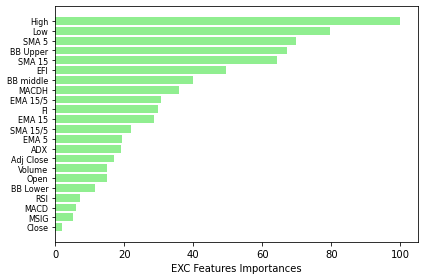

-----


EXC: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,66,286
Actual 1,66,327


Accuracy Score : 0.5275167785234899
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.19      0.27       352
         1.0       0.53      0.83      0.65       393

    accuracy                           0.53       745
   macro avg       0.52      0.51      0.46       745
weighted avg       0.52      0.53      0.47       745



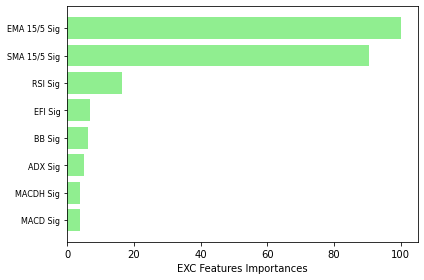


----------------------- F -----------------------


F: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,176,160
Actual 1,211,198


Accuracy Score : 0.5020134228187919
Classification Report
              precision    recall  f1-score   support

        -1.0       0.45      0.52      0.49       336
         1.0       0.55      0.48      0.52       409

    accuracy                           0.50       745
   macro avg       0.50      0.50      0.50       745
weighted avg       0.51      0.50      0.50       745



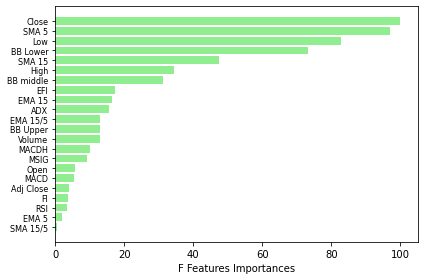

-----


F: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,97,239
Actual 1,121,288


Accuracy Score : 0.5167785234899329
Classification Report
              precision    recall  f1-score   support

        -1.0       0.44      0.29      0.35       336
         1.0       0.55      0.70      0.62       409

    accuracy                           0.52       745
   macro avg       0.50      0.50      0.48       745
weighted avg       0.50      0.52      0.50       745



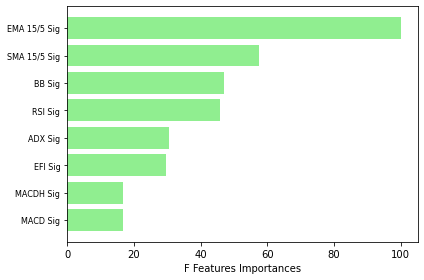


----------------------- GBPUSD=X -----------------------


GBPUSD=X: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,294,88
Actual 1,138,245


Accuracy Score : 0.7045751633986929
Classification Report
              precision    recall  f1-score   support

        -1.0       0.68      0.77      0.72       382
         1.0       0.74      0.64      0.68       383

    accuracy                           0.70       765
   macro avg       0.71      0.70      0.70       765
weighted avg       0.71      0.70      0.70       765



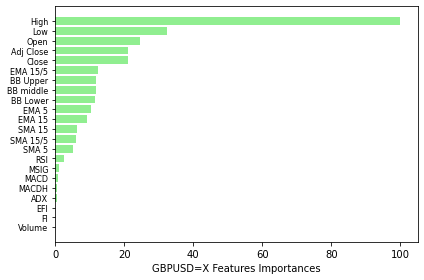

-----


GBPUSD=X: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,242,140
Actual 1,251,132


Accuracy Score : 0.4888888888888889
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.63      0.55       382
         1.0       0.49      0.34      0.40       383

    accuracy                           0.49       765
   macro avg       0.49      0.49      0.48       765
weighted avg       0.49      0.49      0.48       765



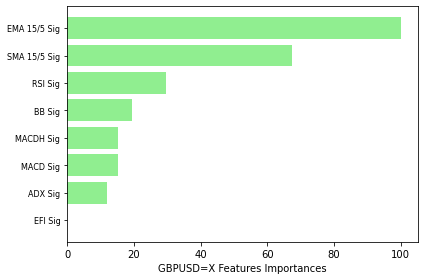


----------------------- GOOG -----------------------


GOOG: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,130,209
Actual 1,152,254


Accuracy Score : 0.5154362416107383
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.38      0.42       339
         1.0       0.55      0.63      0.58       406

    accuracy                           0.52       745
   macro avg       0.50      0.50      0.50       745
weighted avg       0.51      0.52      0.51       745



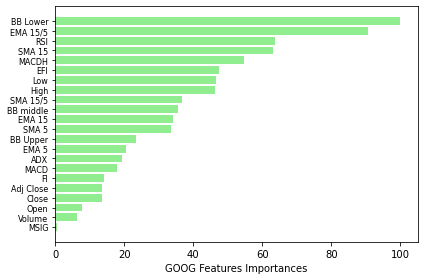

-----


GOOG: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,84,255
Actual 1,117,289


Accuracy Score : 0.5006711409395973
Classification Report
              precision    recall  f1-score   support

        -1.0       0.42      0.25      0.31       339
         1.0       0.53      0.71      0.61       406

    accuracy                           0.50       745
   macro avg       0.47      0.48      0.46       745
weighted avg       0.48      0.50      0.47       745



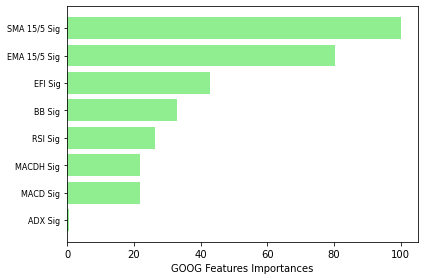


----------------------- Gold -----------------------


Gold: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,143,239
Actual 1,129,234


Accuracy Score : 0.5060402684563758
Classification Report
              precision    recall  f1-score   support

        -1.0       0.53      0.37      0.44       382
         1.0       0.49      0.64      0.56       363

    accuracy                           0.51       745
   macro avg       0.51      0.51      0.50       745
weighted avg       0.51      0.51      0.50       745



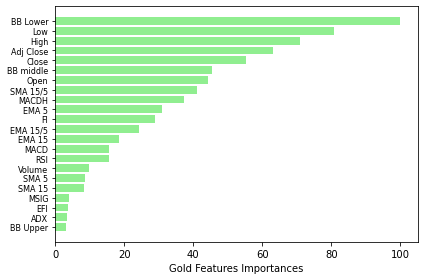

-----


Gold: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,100,282
Actual 1,102,261


Accuracy Score : 0.48456375838926175
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.26      0.34       382
         1.0       0.48      0.72      0.58       363

    accuracy                           0.48       745
   macro avg       0.49      0.49      0.46       745
weighted avg       0.49      0.48      0.46       745



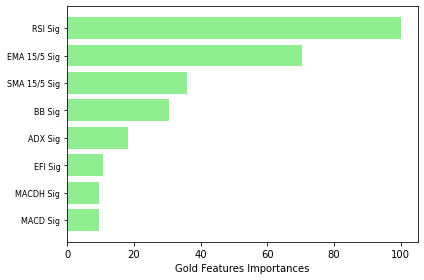


----------------------- HYG -----------------------


HYG: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,77,272
Actual 1,81,315


Accuracy Score : 0.5261744966442953
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.22      0.30       349
         1.0       0.54      0.80      0.64       396

    accuracy                           0.53       745
   macro avg       0.51      0.51      0.47       745
weighted avg       0.51      0.53      0.48       745



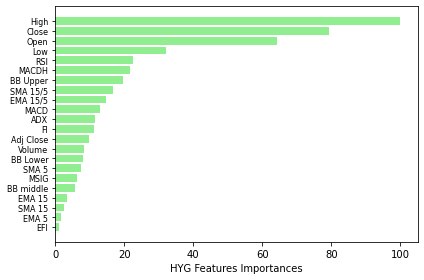

-----


HYG: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,55,294
Actual 1,54,342


Accuracy Score : 0.5328859060402684
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.16      0.24       349
         1.0       0.54      0.86      0.66       396

    accuracy                           0.53       745
   macro avg       0.52      0.51      0.45       745
weighted avg       0.52      0.53      0.46       745



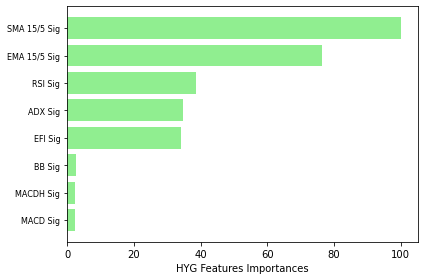


----------------------- JPM -----------------------


JPM: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,158,184
Actual 1,177,226


Accuracy Score : 0.5154362416107383
Classification Report
              precision    recall  f1-score   support

        -1.0       0.47      0.46      0.47       342
         1.0       0.55      0.56      0.56       403

    accuracy                           0.52       745
   macro avg       0.51      0.51      0.51       745
weighted avg       0.51      0.52      0.52       745



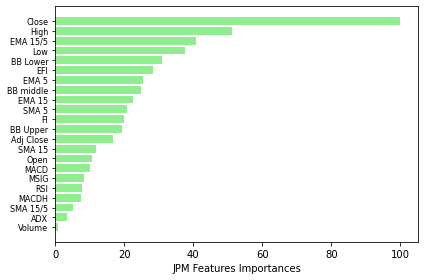

-----


JPM: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,85,257
Actual 1,120,283


Accuracy Score : 0.49395973154362416
Classification Report
              precision    recall  f1-score   support

        -1.0       0.41      0.25      0.31       342
         1.0       0.52      0.70      0.60       403

    accuracy                           0.49       745
   macro avg       0.47      0.48      0.46       745
weighted avg       0.47      0.49      0.47       745



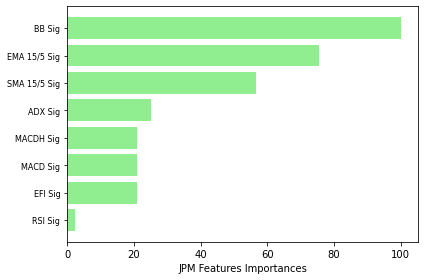


----------------------- KO -----------------------


KO: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,90,258
Actual 1,93,304


Accuracy Score : 0.5288590604026846
Classification Report
              precision    recall  f1-score   support

        -1.0       0.49      0.26      0.34       348
         1.0       0.54      0.77      0.63       397

    accuracy                           0.53       745
   macro avg       0.52      0.51      0.49       745
weighted avg       0.52      0.53      0.50       745



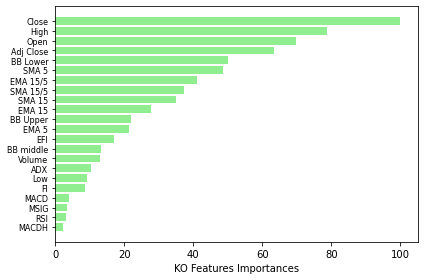

-----


KO: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,46,302
Actual 1,65,332


Accuracy Score : 0.5073825503355704
Classification Report
              precision    recall  f1-score   support

        -1.0       0.41      0.13      0.20       348
         1.0       0.52      0.84      0.64       397

    accuracy                           0.51       745
   macro avg       0.47      0.48      0.42       745
weighted avg       0.47      0.51      0.44       745



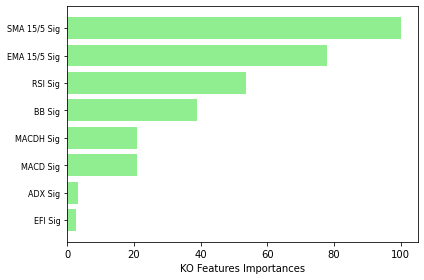


----------------------- LQD -----------------------


LQD: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,42,288
Actual 1,49,366


Accuracy Score : 0.5476510067114094
Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.13      0.20       330
         1.0       0.56      0.88      0.68       415

    accuracy                           0.55       745
   macro avg       0.51      0.50      0.44       745
weighted avg       0.52      0.55      0.47       745



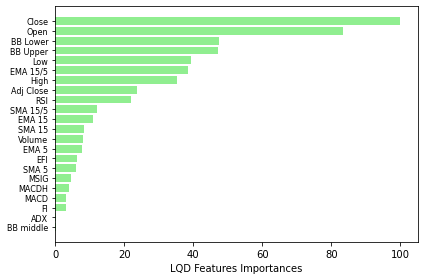

-----


LQD: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,0,330
Actual 1,4,411


Accuracy Score : 0.5516778523489932
Classification Report
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       330
         1.0       0.55      0.99      0.71       415

    accuracy                           0.55       745
   macro avg       0.28      0.50      0.36       745
weighted avg       0.31      0.55      0.40       745



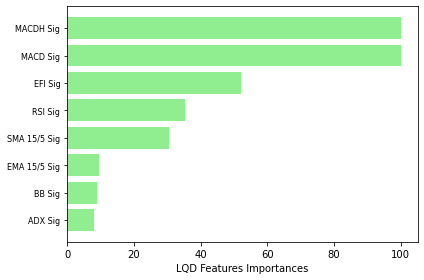


----------------------- MMM -----------------------


MMM: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,28,322
Actual 1,25,370


Accuracy Score : 0.5342281879194631
Classification Report
              precision    recall  f1-score   support

        -1.0       0.53      0.08      0.14       350
         1.0       0.53      0.94      0.68       395

    accuracy                           0.53       745
   macro avg       0.53      0.51      0.41       745
weighted avg       0.53      0.53      0.43       745



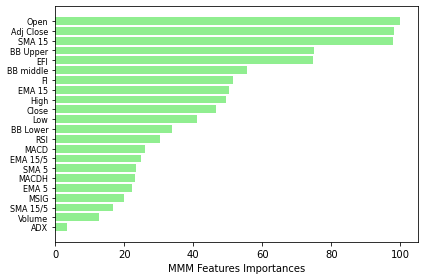

-----


MMM: Confusion Matrix (Signals Only, No Indicators)


,Predicted 0,Predicted 1
Actual 0,17,333
Actual 1,15,380


Accuracy Score : 0.5328859060402684
Classification Report
              precision    recall  f1-score   support

        -1.0       0.53      0.05      0.09       350
         1.0       0.53      0.96      0.69       395

    accuracy                           0.53       745
   macro avg       0.53      0.51      0.39       745
weighted avg       0.53      0.53      0.41       745



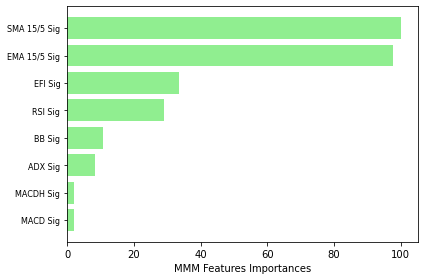


----------------------- MSCI Europe -----------------------


MSCI Europe: Confusion Matrix (Indicators Only, No Signals)


,Predicted 0,Predicted 1
Actual 0,148,1667
Actual 1,147,1904


Accuracy Score : 0.5307811691670977
Classification Report
              precision    recall  f1-score   support

        -1.0       0.50      0.08      0.14      1815
         1.0       0.53      0.93      0.68      2051

    accuracy                           0.53      3866
   macro avg       0.52      0.50      0.41      3866
weighted avg       0.52      0.53      0.43      3866



In [ ]:
for file in data_files:
    tmp_df = pd.read_csv(Path(file), index_col="Date")
    ticker = tmp_df.Ticker.unique().tolist()[0]
    print(f'\n----------------------- {ticker} -----------------------\n')
    
    # Calculate indicators and prepare data
    tmp_df = add_indicators_and_signals(tmp_df)

    # Use only the indicator values, no signals
    # Make predictions and display confusion matrix
    log_reg_model, X_columns = log_reg_indicators_only(tmp_df, ticker)

    # Display importance features graph
    features_importances(ticker, log_reg_model, X_columns)
    
    print("-----\n")
    
    # Use only the signal values no indicator values
    # Make predictions and display confusion matrix
    log_reg_model, X_columns = log_reg_signals_only(tmp_df, ticker)
    
    # Display importance features graph
    features_importances(ticker, log_reg_model, X_columns)
    